# Assembly Tree Generation and Evaluation

## Formulation
 - State Space S = {Every Possible Subassembly}
 - Action Space A = {Every Connection that can currently be removed}
 - P(s'|s,a) = Feasability Checks
 - R(s,a) = Cost of removing a certain + the 
 - Graph Assumption for modelling the 

## Notes
 - Next Steps:
     - Randomly generate rewards and show pathing possible
     - Rewards as a distance cost


In [1]:
import sys, random, math, time
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

## Preliminary Code (Object Classes)

In [2]:
class part:
    def __init__(self, number):
        self.num = number
        self.length = 1
        self.width = 1
        self.pos = []
        self.vel = []
    
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)
    def __str__(self):
        return "Part " + str(self.num)
    def __repr__(self):
        return "Part " + str(self.num)

# HELPER FUNCTIONS

In [3]:
def hierarchy_pos(G, root=None, width=20., vert_gap = 0.4, vert_loc = 0, xcenter = 0.5):  
    # From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):   
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos          
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


# Generating Subassemblies in a recursive manner
def recurGen(p, H, G):
    currCon = list(H.edges())
    if(len(currCon) > 0):
        i = G.number_of_nodes() + 1
        for c in currCon:
            Hnew = H.copy()
            Hnew.remove_edges_from([c])
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                idString = str(Hnew.edges())
                nextState = next((x for x, y in nx.get_node_attributes(G,'idS').items() if y == idString), None)
                if(nextState is not None):
                    Rew, Hnew = R(p,c,H)
                    G.add_edge(p,nextState, a=c, r=Rew)
                else:
                    G.add_node(i, idS=idString)
                    Rew, Hnew = R(p,c,H)
                    G.add_edge(p,i, a=c, r=Rew)
                    G = recurGen(i, Hnew, G)
            i = G.number_of_nodes() + 1
        return G
    else:
        return G
    
    
# Checking Feasability
def P(sN, s, a):
    # Geometric Feasability
    pass
    # Sequential Constraints again


def Rcaz(s,a,H): # Reward Function Assuming there is a CAZ (newest numbers)
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                if(Hnew.nodes[i[0]]["loc"] == "CL"): # Going from CL to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV
                else: # Going from CAZ to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0403 + 0.0420) #SV-CAZ + CAZ-SV

            elif(len(i) == 2): # Have to fix last bit problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0415) #SV-CL + CL-CAZ2

            elif(len(i) == 3): # Have to fix last problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0475) #SV-CL + CL-CAZ3
    return Rewards[(s,a)], Hnew


def RNOcaz(s,a,H): # Reward Function Assuming there is NO CAZ (constructed at SV)
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
#                 if(Hnew.nodes[i[0]]["loc"] == "CL"): # Going from CL to SV
#                     Hnew.nodes[i[0]]["loc"] = "SV"
                Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV

            elif(len(i) == 2): # Have to fix last bit problem
#                 for p in i:
#                     if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
#                         Hnew.nodes[p]["loc"] = "SV"
                Rewards[(s,a)] += -(0.0749 + 0.0499) #SV-CL + CL-SV2

            elif(len(i) == 3): # Have to fix last problem
#                 for p in i:
#                     if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
#                         Hnew.nodes[p]["loc"] = "SV"
                Rewards[(s,a)] += -(0.0869 + 0.0499) #SV-CL + CL-SV3
    return Rewards[(s,a)], Hnew

def R(s, a, H):
    if((s,a) not in Rewards.keys()):
        Rewards[(s,a)], Hnew = Rcaz(s,a,H)
    return Rewards[(s,a)], Hnew







# def Rold(s, a, H):
#     if((s,a) not in Rewards.keys()):
#         Rewards[(s,a)] = 0
        
#         APieces = list(nx.connected_components(H))
#         Hnew = H.copy()
#         Hnew.remove_edges_from([a])
#         BPieces = list(nx.connected_components(Hnew))
#         if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
#             Rewards[(s,a)] = 1
#         elif(len(BPieces) - len(APieces) > 0):
#             diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
#             # Check if removing last connection for a given part
#             for i in diffPieces:
#                 # Check if creating multiple assemblies and sizes of these new assemblies
#                 if(len(i) == 1):
#                     if(Hnew.nodes[i[0]]["loc"] == "CL"): # Going from CL to SV
#                         Hnew.nodes[i[0]]["loc"] = "SV"
#                         Rewards[(s,a)] += -(0.0522 + 0.0399) #SV-CL + CL-SV
#                     else: # Going from CAZ to SV
#                         Hnew.nodes[i[0]]["loc"] = "SV"
#                         Rewards[(s,a)] += -(0.0403 + 0.0420) #SV-CAZ + CAZ-SV
                
#                 if(len(i) == 2):
#                     for p in i:
#                         if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
#                             Hnew.nodes[p]["loc"] = "CAZ"
#                             Rewards[(s,a)] += -(0.0501 + 0.0519) #SV-CL + CL-CAZ2
                    
#                 if(len(i) == 3):
#                     for p in i:
#                         if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
#                             Hnew.nodes[p]["loc"] = "CAZ"
#                             Rewards[(s,a)] += -(0.0501 + 0.0832) #SV-CL + CL-CAZ3
#     return Rewards[(s,a)], Hnew

## Scenario Initialization

In [29]:
# Initialize the inputs (will later read in from file [JSON])

#define topology 
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(1,4)
H.add_edge(5,4)
H.add_edge(5,2)
H.add_edge(6,5)
H.add_edge(6,3)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = int(sum([float(math.factorial(numConnections))/float(math.factorial(i)) for i in range(0, numConnections)]))
numStates = numActions+1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

CONFIGURATION: 
	6 Parts,
	7 Connections in Assembly,
	13700 Subassemblies, 
	13699 Potential Edges, 
	0 Sequential Constraints


## Running the Assembly Generation

In [30]:
# Simple initial initialization (will later read in from file [JSON])
Rewards = {}

# Generate the assembly tree
start = time.time()
G = nx.DiGraph()
G.add_node(1, idS=str(H.edges()))
G = recurGen(1, H, G)
end = time.time()
print("Assembly Generation Time: %f" % (end-start))


print(list(H.edges()))
print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

Assembly Generation Time: 0.041777
[(1, 2), (1, 4), (2, 3), (2, 5), (3, 6), (4, 5), (5, 6)]
DONE: 128 Nodes and 448 Edges


## Value Iteration

In [31]:
def ValueIteration(G, H, maxIter, eps):
    S = range(1, G.number_of_nodes()+1)
    A = list(H.edges())

    V = {s: 2 for s in S}
    Vnew = V.copy()
    π = {s: (0, (0,0)) for s in S}
    delta = max([abs(V[s] - Vnew[s]) for s in S])

    c = 0
    while(c <= maxIter):
        delta = 0
        for s in S:
            nextStates = G[s]
            for sN in nextStates.items():
                newV = sN[1]['r'] + V[sN[0]]
                if(newV < Vnew[s]):
                    Vnew[s] = newV
                    π[s] = (sN[0], sN[1]['a'])
        delta = max([abs(V[s] - Vnew[s]) for s in S])
        if(delta < eps):
            print("Converged!")
            return Vnew, π
        V = Vnew.copy()
        c += 1
    print("Done")

maxIter = 100000
eps = 1e-8
start = time.time()
V, π = ValueIteration(G, H, maxIter, eps)
end = time.time()
print("Value Iteration Time: %f" % (end-start))

try:
    S = range(1, G.number_of_nodes()+1)
    path = [1, π[1][0]]
    path_edges = [(1, path[-1])]
    dissassemblyStrat = [π[path[0]][1], π[path[-1]][1]]
    while(True):
        currState = path[-1]
        print(π[currState])
        nextState = π[currState][0]
        if(nextState in S):
            path.append(nextState)
            path_edges.append((currState, nextState))
            dissassemblyStrat.append(π[nextState][1])
        else:
            break
    print(path_edges)
    print(dissassemblyStrat)
except:
    print("No Policy Found")

Converged!
Value Iteration Time: 0.002144
(51, (2, 5))
(58, (5, 6))
(27, (1, 4))
(12, (2, 3))
(9, (3, 6))
(0, (0, 0))
[(1, 2), (2, 51), (51, 58), (58, 27), (27, 12), (12, 9)]
[(1, 2), (2, 5), (5, 6), (1, 4), (2, 3), (3, 6), (0, 0)]


In [37]:
costs = nx.get_edge_attributes(G,'r')
e = [(i[0], i[1], -costs[i]) for i in costs.keys()]
G.add_weighted_edges_from(e)

start = time.time()
path = nx.dijkstra_path(G, 1, H.number_of_edges()+1)
end = time.time()
print("Dijkstra Path Time: %f" % (end-start))

print(path)

last = None
disStrat = []
for i in path:
    if(last is not None):
        disStrat.append(G.edges[last, i]['a'])
    print(i, G.nodes()[i])
    last = i
    
print("Connection Removal:", disStrat)

Ha = H.copy()
pos = nx.spring_layout(Ha)

Dijkstra Path Time: 0.000290
[1, 2, 35, 4, 5, 12, 9, 8]
1 {'idS': '[(1, 2), (1, 4), (2, 3), (2, 5), (3, 6), (4, 5), (5, 6)]'}
2 {'idS': '[(1, 4), (2, 3), (2, 5), (3, 6), (4, 5), (5, 6)]'}
35 {'idS': '[(1, 4), (2, 5), (3, 6), (4, 5), (5, 6)]'}
4 {'idS': '[(2, 5), (3, 6), (4, 5), (5, 6)]'}
5 {'idS': '[(3, 6), (4, 5), (5, 6)]'}
12 {'idS': '[(3, 6), (4, 5)]'}
9 {'idS': '[(4, 5)]'}
8 {'idS': '[]'}
Connection Removal: [(1, 2), (2, 3), (1, 4), (2, 5), (5, 6), (3, 6), (4, 5)]


# Graphing Suite

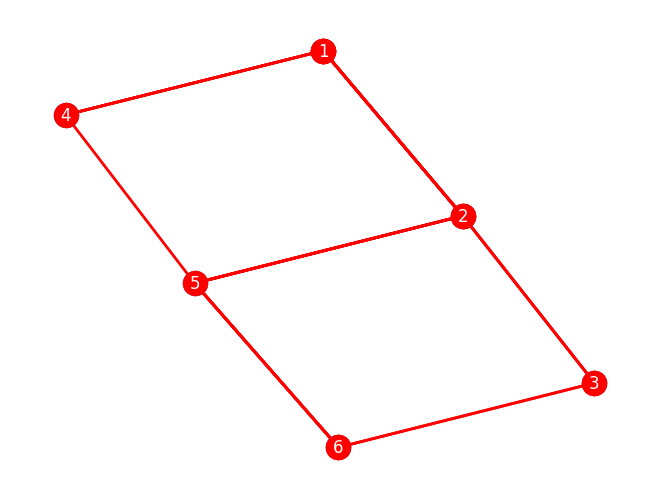

In [38]:
nx.draw(H, pos, with_labels=True, font_color="#FFFFFF")
plt.savefig('./2x3/'+str(0)+'.png')
dissassemblyStrat[-1] = (4,5)
strat = dissassemblyStrat

for i in range(len(strat)):
    nx.draw_networkx_edges(H, pos, edgelist=strat[0:i+1], edge_color='r', width=2)
    Ha.remove_edges_from([strat[i]])
    for p in nx.isolates(Ha):
        nx.draw_networkx_nodes(H,pos,nodelist=[p],node_color='r')
    plt.savefig('./2x3/'+str(i+1)+'.png')

No Policy Found
DONE: 128 Nodes and 448 Edges


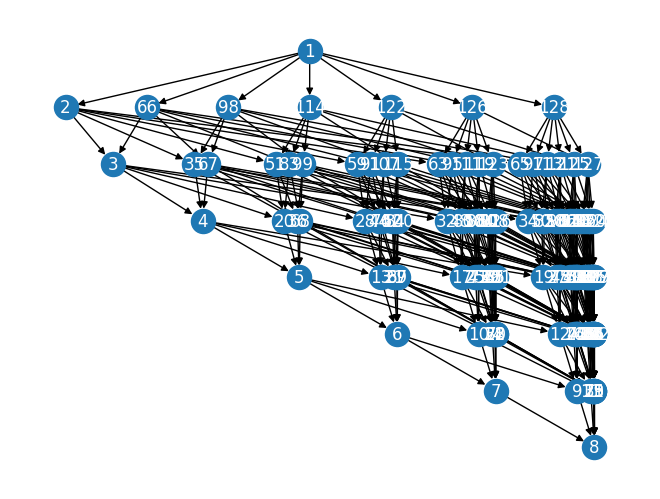

In [35]:
debug = False

if(debug):
    try:
        pos = hierarchy_pos(G,1)
    except:
        pos = nx.planar_layout(G)
    actions = nx.get_edge_attributes(G,'r')
    nx.draw(G, pos, with_labels=True, font_color="#FFFFFF")
    #nx.draw_networkx_edge_labels(G, pos, edge_labels = actions)


    try:
        a = 1/0
        S = range(1, G.number_of_nodes()+1)
        path = [1, π[1][0]]
        path_edges = [(1, path[-1])]
        while(True):
            currState = path[-1]
            nextState = π[currState][0]
            if(nextState in S):
                path.append(nextState)
                path_edges.append((currState, nextState))
            else:
                break
        print(path_edges)
        nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='r')
        nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='r',width=1)
    except:
        print("No Policy Found")

    print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

In [10]:
if(debug):
    V = G.copy()
    try:
        plotVis(V)
    except:
        try:
            plotVis(V)
        except:
            print("Nope!")